In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML

In [2]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras import regularizers
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf

%matplotlib inline

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2456786652423810216
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4986830848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 308151975071245161
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


# Data processing

In [4]:
#Defining the train data
X_k_train = pd.read_csv('kmnist_train.csv').drop(columns='output').values
y_k_train = pd.read_csv('kmnist_train.csv')["output"].values

#Defining the test data
X_k_test = pd.read_csv('kmnist_test.csv').values

#Reshaping
X_k_train = X_k_train.reshape(len(X_k_train),28,28)/255.
X_k_test = X_k_test.reshape(len(X_k_test),28,28)/255.

print(f'The shapes of the test and training dataset are: \n     Train: {X_k_train.shape}\n     Test: {X_k_test.shape}')

The shapes of the test and training dataset are: 
     Train: (1200, 28, 28)
     Test: (2000, 28, 28)


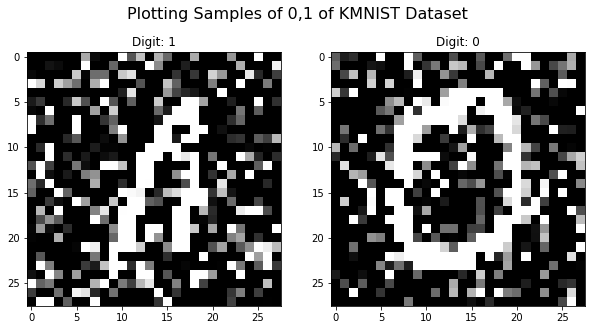

In [5]:
#Plotting digits 1 and 0
img_id = [1,2]
plot_id = [0,1]

fig, ax = plt.subplots(1,2,figsize=(10,5))
plt.suptitle('Plotting Samples of 0,1 of KMNIST Dataset',fontsize=16)

for a,b in zip(img_id,plot_id):
    ax[b].imshow(X_k_train[a],'gray')
    ax[b].set_title(f'Digit: {y_k_train[a]}')


# FCN Construction

In [6]:
model_overfit = tf.keras.models.Sequential()

#Hidden Layer 1
model_overfit.add(tf.keras.layers.Dense(100,activation='relu', input_shape=(784,)))
#Hidden Layer 2
model_overfit.add(tf.keras.layers.Dense(100,activation='relu'))
#Hidden Layer 3
model_overfit.add(tf.keras.layers.Dense(100,activation='relu'))

#Output Layer
model_overfit.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model_overfit.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
model_overfit.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Model Fitting
    #Epochs = 1500
    #Batch_size = 128
    
history_overfit = model_overfit.fit(X_k_train.reshape(len(X_k_train),28*28),y_k_train,
                           validation_split=0.3,
                           batch_size=128,
                           epochs=2000)

Train on 840 samples, validate on 360 samples
Epoch 1/2000
840/840 [==============================] - 1s 875us/sample - loss: 0.6815 - accuracy: 0.5179 - val_loss: 0.6652 - val_accuracy: 0.4944
Epoch 2/2000
840/840 [==============================] - 0s 42us/sample - loss: 0.6523 - accuracy: 0.6560 - val_loss: 0.6532 - val_accuracy: 0.4944
Epoch 3/2000
840/840 [==============================] - 0s 40us/sample - loss: 0.6071 - accuracy: 0.7286 - val_loss: 0.5629 - val_accuracy: 0.7472
Epoch 4/2000
840/840 [==============================] - 0s 39us/sample - loss: 0.5227 - accuracy: 0.8286 - val_loss: 0.4521 - val_accuracy: 0.9139
Epoch 5/2000
840/840 [==============================] - 0s 37us/sample - loss: 0.4080 - accuracy: 0.9060 - val_loss: 0.3666 - val_accuracy: 0.8611
Epoch 6/2000
840/840 [==============================] - 0s 39us/sample - loss: 0.3071 - accuracy: 0.9083 - val_loss: 0.2442 - val_accuracy: 0.9417
Epoch 7/2000
840/840 [==============================] - 0s 38us/sample 

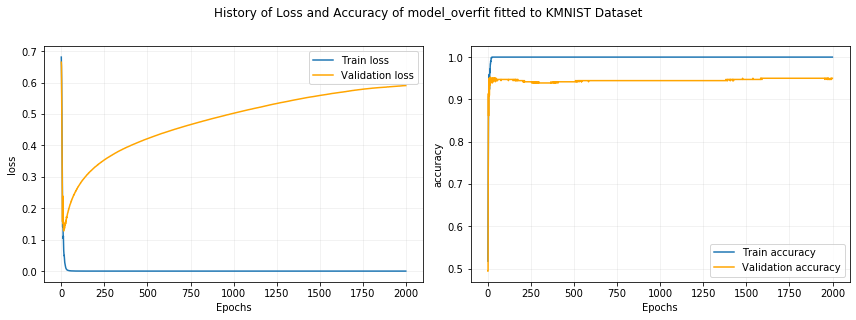

In [11]:
#Plotting the loss and Accuracy
fig,ax = plt.subplots(1,2,figsize=(12,4))

plt.suptitle('History of Loss and Accuracy of model_overfit fitted to KMNIST Dataset', y=1.1)
for i, metric in enumerate(['loss','accuracy']):
    ax[i].plot(history_overfit.history[metric], label='Train '+metric)
    ax[i].plot(history_overfit.history['val_'+metric],color='orange',label='Validation '+metric)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(loc='best')
    ax[i].grid(alpha=0.2)
plt.tight_layout()

# Regularized FCN Construction

In [70]:
model_reg = tf.keras.models.Sequential()

#Regualrization term
L2 = tf.keras.regularizers.l2(0.025)

#Hidden Layer 1
model_reg.add(tf.keras.layers.Dense(100,activation='relu', input_shape=(784,),kernel_regularizer=L2))
#Hidden Layer 2
model_reg.add(tf.keras.layers.Dense(100,activation='relu',kernel_regularizer=L2))
#Hidden Layer 3
model_reg.add(tf.keras.layers.Dense(100,activation='relu',kernel_regularizer=L2))
#Output Layer
model_reg.add(tf.keras.layers.Dense(1,activation='sigmoid',kernel_regularizer=L2))

In [71]:
model_reg.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model_reg.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_41 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_42 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 101       
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


In [72]:
history_reg = model_reg.fit(X_k_train.reshape(len(X_k_train),28*28),y_k_train,
             validation_split=0.3,
             batch_size=128,
             epochs=2000)

Train on 840 samples, validate on 360 samples
Epoch 1/2000
840/840 [==============================] - 1s 681us/sample - loss: 9.4713 - accuracy: 0.5417 - val_loss: 8.5349 - val_accuracy: 0.4944
Epoch 2/2000
840/840 [==============================] - 0s 39us/sample - loss: 7.9651 - accuracy: 0.5250 - val_loss: 7.1669 - val_accuracy: 0.4917
Epoch 3/2000
840/840 [==============================] - 0s 41us/sample - loss: 6.6861 - accuracy: 0.5500 - val_loss: 6.0185 - val_accuracy: 0.4972
Epoch 4/2000
840/840 [==============================] - 0s 39us/sample - loss: 5.6192 - accuracy: 0.5405 - val_loss: 5.0681 - val_accuracy: 0.6139
Epoch 5/2000
840/840 [==============================] - 0s 44us/sample - loss: 4.7386 - accuracy: 0.6857 - val_loss: 4.2917 - val_accuracy: 0.5250
Epoch 6/2000
840/840 [==============================] - 0s 43us/sample - loss: 4.0206 - accuracy: 0.7393 - val_loss: 3.6472 - val_accuracy: 0.8194
Epoch 7/2000
840/840 [==============================] - 0s 40us/sample 

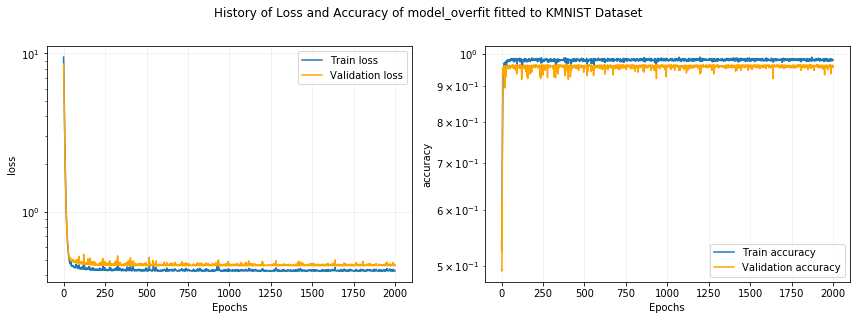

In [73]:
#Plotting the loss and Accuracy
fig,ax = plt.subplots(1,2,figsize=(12,4))

plt.suptitle('History of Loss and Accuracy of model_overfit fitted to KMNIST Dataset', y=1.1)
for i, metric in enumerate(['loss','accuracy']):
    ax[i].semilogy(history_reg.history[metric], label='Train '+metric)
    ax[i].plot(history_reg.history['val_'+metric],color='orange',label='Validation '+metric)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(loc='best')
    ax[i].grid(alpha=0.2)
plt.tight_layout()

In [74]:
loss_diff = history_reg.history['val_loss'][-1] - history_reg.history['loss'][-1] 
acc_diff = history_reg.history['accuracy'][-1] - history_reg.history['val_accuracy'][-1] 
print(f'Difference between Loss and Accuracy of the last epoch: \n     Loss: {loss_diff}\n     Accuracy: {acc_diff}')
print(f'Accuracy: {history_reg.history["accuracy"][-1]:.4}')
print(f'Val Accuracy: {history_reg.history["val_accuracy"][-1]:.4}')

Difference between Loss and Accuracy of the last epoch: 
     Loss: 0.034319117239543395
     Accuracy: 0.019841253757476807
Accuracy: 0.981
Val Accuracy: 0.9611
